In [1560]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread
from scipy.linalg import sqrtm
import pandas as pd
np.random.seed(1234)

In [1561]:
#Muller Brown Potential and Gradient

def MB_potential(x,y):    
    aa = [-1, -1, -6.5, 0.7]
    bb = [0, 0, 11, 0.6]
    cc = [-10, -10, -6.5, 0.7]
    AA = [-200, -100, -170, 15]
    XX = [1, 0, -0.5, -1]
    YY = [0, 0.5, 1.5, 1]
    
    value = 0
    for j in range(0, 4):
        value += AA[j] * np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
    return value
vMB_potential = np.vectorize(Muller_Brown_potential)

def grad_MB(x,y):
    aa = [-1, -1, -6.5, 0.7]
    bb = [0, 0, 11, 0.6]
    cc = [-10, -10, -6.5, 0.7]
    AA = [-200, -100, -170, 15]
    XX = [1, 0, -0.5, -1]
    YY = [0, 0.5, 1.5, 1]
    
    dx = 0
    dy = 0
    for j in range(0, 4):
        dx += AA[j] *(2*aa[j]*(x-XX[j])+bb[j]*(y-YY[j]))* np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
        dy += AA[j] *(2*cc[j]*(y-YY[j])+bb[j]*(x-XX[j]))* np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
    return dx, dy
vgrad_MB = np.vectorize(grad_MB)

def Hessian_MB(x,y):
    
    aa = [-1, -1, -6.5, 0.7]
    bb = [0, 0, 11, 0.6]
    cc = [-10, -10, -6.5, 0.7]
    AA = [-200, -100, -170, 15]
    XX = [1, 0, -0.5, -1]
    YY = [0, 0.5, 1.5, 1]
    
    dxx = 0
    dxy = 0
    dyy = 0
    for j in range(0, 4):
        Phi = AA[j] * np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
        alpha = (2*aa[j]*(x-XX[j])+bb[j]*(y-YY[j]))
        beta = (2*cc[j]*(y-YY[j])+bb[j]*(x-XX[j]))
        dxx += 2*aa[j]*Phi + alpha**2*Phi
        dxy += bb[j]*Phi + bb[j]*(y-YY[j])*beta*Phi
        dyy += 2*cc[j]*Phi + beta**2*Phi
        
    return dxx, dxy, dxy, dyy
vHessian_MB = np.vectorize(Hessian_MB)

In [1562]:
def affine_invariant_wd(N = 5000, learning_rate = 1e-4, mu = 0, sigma = 1):
    intervals = np.arange(1, 1e5, 20)
    #initialise variables (particles)
    dt = learning_rate
    C = sigma**2*np.identity(2)
    mean = np.array([0.2, 1.2])
    #x,y = np.random.multivariate_normal(mean, C)
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    points_x = [x]
    points_y = [y]
    
    beta = 10
    
    for i in trange(1, N+1):
        
        grad = grad_MB(x,y)
        
        dx,dy = - C@grad/beta*dt + np.sqrt(2)*sqrtm(C)@np.random.normal(0,dt,2)
        x += dx
        y += dy
        if i in intervals: 
            points_x.append(x)
            points_y.append(y)

        Z = np.random.multivariate_normal(mean, C, int(1e3))
        X = Z[:,0]
        Y = Z[:,1]
        Dx, Dy = vgrad_MB(X,Y)
        exp_m = np.array([np.mean(Dx), np.mean(Dy)])/beta
        
        Dxx, Dxy, Dyx, Dyy = vHessian_MB(X,Y)
        dxx = np.mean(Dxx)
        dxy = np.mean(Dxy)
        dyx = dxy
        dyy = np.mean(Dyy)
        exp_c = np.array([[dxx, dxy], [dyx, dyy]])/beta**2
        #update mean and covariance matrix
        mean = mean-C@exp_m*dt
        C = C + 2*C*dt-2*C@exp_c@C*dt
        print(x,y)
        
    return points_x, points_y, mean,C

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

-0.1981739627066658 -0.15336669965687064
-0.19817372082484908 -0.1533685321272463
-0.19815315401306188 -0.15334573642900884
-0.19813159542940345 -0.15334026269571757
-0.1981133903312596 -0.153349974219204
-0.19810709327444118 -0.15334875404893022
-0.19808002547819956 -0.15336106070400493
-0.19807547038058068 -0.1533561796386214
-0.19807183941316492 -0.15331650509388436
-0.1980700542262235 -0.15330182223254119
-0.19805374146014088 -0.1533110175482861
-0.198037299464323 -0.15330197913035823
-0.1980570528794542 -0.15330553629929056
-0.1980752722507543 -0.15334248394493752
-0.19807325110436724 -0.15334442521229816
-0.19807682042641647 -0.15336384077638443
-0.19807906839036382 -0.15335100993779868
-0.19809155174323387 -0.15332271043878695
-0.19811473358995366 -0.15333958726212918
-0.1981025300683777 -0.15336769286784982
-0.19810383699198197 -0.15334551492088483
-0.19812797392861925 -0.15335292432511083
-0.19811289299895507 -0.1533491222268213
-0.19810852288404351 -0.15335981217744776
-0.198

-0.19735274932594526 -0.15343827841892746
-0.19734726947132042 -0.1533844549527487
-0.19741366691721085 -0.15351078356750594
-0.19738557217978453 -0.1534407435313116
-0.1975068654563184 -0.1535348235090994
-0.19741309856858935 -0.1535448071038887
-0.19748291456575748 -0.153619460991529
-0.19753831815190928 -0.15357049806572162
-0.1974735199817687 -0.15345949674868817
-0.19755081842321867 -0.15337645350182977
-0.19781318753446475 -0.15352640060079872
-0.19780878187477424 -0.15369137664136495
-0.19776379528862872 -0.15371685358288578
-0.19789256667398072 -0.15389386867733296
-0.19789883424423435 -0.15401669613708463
-0.19768569472443062 -0.1540329964968427
-0.19759074003344287 -0.15413922292303733
-0.19761828794637273 -0.15410219113574553
-0.1974771219738577 -0.15406559397891337
-0.19733834010523243 -0.15393614758157095
-0.19735556630258003 -0.15398581474158352
-0.19723200752003175 -0.1541166446797835
-0.19732341951804577 -0.15407509647101525
-0.1972001062055096 -0.1539380096886832
-0.19

-0.18197829598182247 -0.12555513461717843
-0.1807337569783488 -0.126091978586157
-0.18090271927689414 -0.12546478420982188
-0.18115729033165717 -0.1262685446348455
-0.17963328062323067 -0.12569486608016278
-0.17774697258667707 -0.1256631182871861
-0.1772110478633939 -0.1250725582540342
-0.17646927524079026 -0.12443773153254964
-0.1751799384162572 -0.12383530779638253
-0.17470779651397164 -0.12219665054945794
-0.17451745287706594 -0.12144835396512597
-0.17356374836944388 -0.12037033346974588
-0.17548364698514513 -0.11989076745894561
-0.17665042595049552 -0.12109959584215245
-0.1761774024672222 -0.12053094507876005
-0.17655263838034677 -0.1193203210587499
-0.17589848037542968 -0.11813399291924855
-0.17570008396864728 -0.1179395156994923
-0.17543118981446165 -0.1153531014959998
-0.17558220997917534 -0.11427245732406498
-0.17454375473951736 -0.11394213079103706
-0.17525280929533252 -0.1120663394465216
-0.17570762656489833 -0.11191802058063519
-0.17493390211260462 -0.11059980004919412
-0.17

0.5277484462773564 0.020109819627390956
0.5376755970922427 0.0324404220807733
0.5496920728133162 0.038840059720100704
0.5500847493257669 0.0389479476769416
0.5499408313051799 0.032882399322425454
0.5529888607073912 0.042089095268776515
0.5459095999600669 0.03927052840996691
0.5482292229403486 0.0391444185935551
0.5592741011662391 0.031406372322884776
0.5736321994975637 0.028361379983408756
0.5768213227755883 0.02663390606564593
0.5832131631690206 0.027421042187070387
0.586336851876952 0.03483300664794439
0.5918588892475379 0.017015726358582842
0.6002300825977743 0.032156452888227535
0.6140447375772489 0.03407698292040362
0.6205460234022656 0.04189620553106323
0.6269580583173843 0.038718813660354914
0.6267595587577292 0.03542480526122844
0.6327891617481801 0.027914887525734934
0.6264381649450236 0.027780834732522273
0.6321264341505473 0.04763326650009851
0.6311589583243439 0.042092577637560726
0.6259074312288431 0.027533354492468708
0.6169818664515953 0.020839810676829378
0.621820546820

0.6040091826690871 0.02686449566543877
0.6278788014999167 0.019582708591599364
0.6319868144114159 0.03296939516821837
0.6347193733743011 0.038448613372836525
0.626180199798533 0.03309162373669034
0.6383048107579701 0.0305091650838356
0.632111705367906 0.032980324206658466
0.6455372444483071 0.030702932630001605
0.6376935525323632 0.025922471193731287
0.6505981930253826 0.034232204635487144
0.6599437736748259 0.03026176450914024
0.65834044441526 0.038305816291494876
0.654871976545053 0.029970646681276032
0.6474845142996646 0.024461907034838068
0.6426210245631575 0.0169215821697811
0.6379267858863736 0.037210892192355266
0.6440521206906988 0.02701141237950449
0.6377246125304077 0.03528017468361324
0.6235882903285401 0.015652280850670334
0.6134653818574806 0.029408298662273256
0.617969138484009 0.02026287271534976
0.608926835816633 0.019244022007927526
0.6129243359941628 0.03645205920285234
0.6192410064721902 0.02664977413123793
0.5988745872057669 0.026018484841509558
0.602776486478787 0.

  0%|          | 0/1000 [00:00<?, ?it/s]

0.26860415947047955 -0.010648282896191167
0.26859625750522365 -0.010627322253416508
0.26859679220409405 -0.01060854050519972
0.2685820065814956 -0.01060963510543065
0.26857130746400293 -0.010617681864656541
0.26856289893936053 -0.010590758406940959
0.2685490836839258 -0.010602049884671106
0.26853057095315225 -0.010588511356229137
0.268511256651525 -0.010593544176516628
0.26850946472848203 -0.010598230509570579
0.26848629156766396 -0.010589265746401164
0.2684942692015121 -0.010588910692631357
0.26848760128541527 -0.010580983818692772
0.2684705197428549 -0.010597259457061354
0.26844707188750505 -0.010632221149394924
0.26846011155512184 -0.010622000585790893
0.2684734355504339 -0.010621622030856807
0.26849372834995133 -0.01060810396527338
0.2684556276408303 -0.010601814334977746
0.2684701773658384 -0.01062320075636693
0.26847890927502716 -0.0106349914310177
0.26850250871984765 -0.0106543880071768
0.2684931508065796 -0.010661303304673365
0.26849401920818705 -0.010664373735931687
0.26848194

0.2671990026801525 -0.011278840105973114
0.2672235788635312 -0.01122356309443951
0.2672214146504456 -0.011261823153407796
0.2670766155837628 -0.011044446571122945
0.26718231972935 -0.011105007232554632
0.26699710869395 -0.011193013407894336
0.26714058805071045 -0.01133128596550196
0.26710244930433485 -0.011414220781043352
0.2673927797221089 -0.011522444102153313
0.26751799249030056 -0.011423342792911727
0.26755953566929447 -0.011264025226121408
0.26764319971352113 -0.01113765745210522
0.26757849767170905 -0.011014577538543027
0.2675858891362663 -0.011088594196052199
0.26763203243924966 -0.011135378739285409
0.267637511803499 -0.011269956311152386
0.2677443680746293 -0.011326599374947633
0.2674784098239799 -0.011329603113978159
0.26756573936495714 -0.01124598317265242
0.2676012813757573 -0.011156750955469823
0.2676907004424214 -0.011377886429267903
0.26770085010232236 -0.011135444670338097
0.2677553971175018 -0.011097717887065539
0.2677526696814056 -0.011035014158579909
0.26787568435387

0.2898142332651918 0.011052666343042208
0.29031586271646215 0.010790611824327175
0.2917169499281655 0.01116868155127639
0.2918069381624613 0.012701550635302523
0.2921965669755416 0.011918203287309586
0.29177600916267055 0.011708199031557408
0.29165778709957657 0.012353288390193146
0.29164240256507384 0.011476953269306079
0.2923828872085506 0.012382102439679195
0.2921215546096201 0.012311905901065
0.2928516400543254 0.011538559923647187
0.2930804503754015 0.011488333191404625
0.29329142533440783 0.012673798733347928
0.29409354644245866 0.013455279951711923
0.2949690305831924 0.013050993476694736
0.29403711298396495 0.013351665618642384
0.2938435169941791 0.014196458698854072
0.2940333214954404 0.015258050317439703
0.29345690995152235 0.01711670560708998
0.2923325861462957 0.01606487317003467
0.2914038105498198 0.01609766562651435
0.29122308465210456 0.01767692613198536
0.2927915577545605 0.017188764258951803
0.29528096405654713 0.018413161265338887
0.2964308666982463 0.01781509648645206

0.6521558810051954 0.02848547491194111
0.6489371681712091 0.02272190707677611
0.6430607858563702 0.02530020652189937
0.6532346180873756 0.017570582072182116
0.6463333193496194 0.010439537425232933
0.6575011404176779 0.023820480536671573
0.6530202425233381 0.02898291430971645
0.6596590087884386 0.029165442796695983
0.6580683212230564 0.029180722873093697
0.6643763472824975 0.0400318805822366
0.6558084233825014 0.02415263534523583
0.644501622673408 0.021313075450280987
0.646317333771661 0.03830893137463632
0.6559963880573774 0.015900563152875566
0.642063146049783 0.028391759211920876
0.6369678287925077 0.02865073727985708
0.6365319991806183 0.02149833795218863
0.6259447990468402 0.03322425183278546
0.6326131379181743 0.02031118207147905
0.6401312808273832 0.04599202910636721
0.6314668863206987 0.019177637812976454
0.6268049595158979 0.035464966161488184
0.6147399359673535 0.029178202520428957
0.6154858910558727 0.029662166462325182
0.6016969493920749 0.03313301443848434
0.615439802835384

0.6582595520549666 0.03271213310291178
0.6390172827258552 0.02826509098286879
0.6295743591604832 0.028558111381585944
0.6195870366353468 0.030772236253189998
0.6474976407686341 0.030797293025693416
0.6359200892485751 0.028656355960262565
0.6252599773380418 0.02801727089586179
0.6130430668547934 0.03860595378600767
0.6167156014010231 0.024457707906340893
0.6114131874432671 0.032056585708257083
0.616750353929934 0.03449931131319431
0.6189423814817812 0.006263645726580114
0.6134619182168167 0.038981863482868175
0.617451608083141 0.009481994557458451
0.6061332982407204 0.0372450179925025
0.6023482193629364 0.01862980880688527
0.6108735201620247 0.03854108520696188
0.6140006179311926 0.03047364406066049
0.6203164972414689 0.036184507778602805
0.6177911903369845 0.02749788134298936
0.6321085389960852 0.030184429490115645
0.6335008901775565 0.02607755309574062
0.6385234292859936 0.03844450917842996
0.6386500137336397 0.01713753888128846
0.6395033151667405 0.022583288968235117
0.64110949679150

  0%|          | 0/1000 [00:00<?, ?it/s]

1.0576741420637292 0.009087709039616929
1.0576755960209432 0.009075100880996901
1.0576864320097745 0.009082852789061752
1.0576755551818933 0.009089993153203866
1.0576642142136272 0.009106957538820805
1.057640928260171 0.009096379999734653
1.0576545220080427 0.00908049467766924
1.0576561019898552 0.009118198694790868
1.0576615883923566 0.009121062656034696
1.0576599472421198 0.00910531403750838
1.0576690018924495 0.0091152308563587
1.0576992790827635 0.00912619236419374
1.0577113515763834 0.009126023205021061
1.0577232619214834 0.009112038850493567
1.0577134859174595 0.009145662615532683
1.0577249634327657 0.00914542288667381
1.0577181387906014 0.009163163432747272
1.057718495353696 0.009171778040921145
1.057735091346129 0.009161247315446774
1.057731315351493 0.009140992413722172
1.0577161887419786 0.00915120699572205
1.0577191760036921 0.00913385399711565
1.057732765981311 0.009137188468326255
1.0577413267744646 0.009117937979528323
1.0577060638714815 0.009099201007495752
1.05770817780

1.057103592533383 0.00979250409804859
1.05715055479925 0.00980485471923956
1.056856749066433 0.009806254823633174
1.0567393602244153 0.009679577375588801
1.0566342324271105 0.009931164899295943
1.0567891183162306 0.009909841928385453
1.056737718843206 0.009942872181450093
1.0567630932620897 0.009936586601771286
1.0571359521993564 0.010058436355788316
1.0572101723396852 0.009933588458739113
1.0571230404985634 0.009964021665736969
1.0572521857886756 0.010061588928400433
1.0573745356014201 0.009822848582148191
1.0574871055719466 0.00993181237389612
1.0573909929109773 0.009810315194411598
1.0574617065601133 0.009856124355049354
1.0574257536168166 0.01012466787755495
1.057464596798768 0.009968040128400113
1.0575147932934619 0.01003718567152129
1.0573582439033054 0.010084557877192627
1.0572954115079392 0.00992372314428165
1.057190219975482 0.00976936943373987
1.0568395252730565 0.00982264907251519
1.0569997059182312 0.010014696156184746
1.0571385222775436 0.009813357870333054
1.0570085310514

0.9865274306523364 0.013330969491279755
0.9846843840183268 0.011947803904514817
0.983180194375851 0.012437366101605318
0.9826476944054999 0.010104958970895164
0.9816555459414738 0.010036955279104939
0.9806027339303576 0.010880292261652122
0.980709311798196 0.012236325986393643
0.9804007733036237 0.012441287136375647
0.9796366819589437 0.011576478068326866
0.9784885364194742 0.012309682411579866
0.978491658704287 0.011613147340064613
0.9772360134647523 0.012296400135854505
0.9767870968693237 0.013217956353839825
0.9758876940435821 0.014988134205010927
0.9749501377777513 0.01445489092482337
0.9725391960606302 0.015543625207831351
0.9704282076383243 0.01648128231545427
0.969257815512697 0.014991797537073508
0.9689495397290698 0.013385403744256116
0.966552884535314 0.014832722463467823
0.9645292682767068 0.014550191663367722
0.9618120253617269 0.016166559447270235
0.9605040222809442 0.01666890095268274
0.9573643860647165 0.01599848296204477
0.9553058683307413 0.016313662198085863
0.9514333

0.610974236208709 0.04175969591979306
0.6126106505682255 0.027412248789605336
0.623949765386371 0.03101863725088392
0.6366201572391619 0.029220589760178453
0.6265179643066185 0.03209578897609478
0.621951921922842 0.012389249503858099
0.6225986096118069 0.023934924922367318
0.6199989631296664 0.022459474927493523
0.6160145712983697 0.025332059885050547
0.6156084703548355 0.03543712689754652
0.6263898578368655 0.03695831442090456
0.6326977572374433 0.0303292567873419
0.6296059688641182 0.03310096938739818
0.6227225056576122 0.037675039383723866
0.6174905585373162 0.028517294759074274
0.6153911738237648 0.021072344551925026
0.6278088802178109 0.039356914664153364
0.6141039085721416 0.01913604990735827
0.6165181293268661 0.030771915203899942
0.6081393062794552 0.03020828771439863
0.6145135623455157 0.030118176078820336
0.6158958062059154 0.02954488135439303
0.6134480087531503 0.01185070848643617
0.6201261893066763 0.03544157685226812
0.6127916992859563 0.02791743743255855
0.610845562392470

0.6349847722262932 0.020893480275240038
0.6363815548373928 0.01772982147709149
0.629431896494096 0.029703875069105372
0.6215719908565264 0.0008558071168336331
0.6013132828281625 0.041117354904549284
0.620657218907799 0.009132088294654929
0.6181956590706801 0.04651427005390747
0.6290517627773335 0.024933796367068734
0.6089782618069155 0.034976028443176474
0.6213814317799079 0.016726253496918312
0.6227973308888916 0.03853967312554597
0.619765445259103 0.023038823578870746
0.5960453331131979 0.04387787370166189
0.6077563211222105 0.01774432254779165
0.6063075072601081 0.04509019230839416
0.6262690708735404 0.01782503865572567
0.6302120249775696 0.040506281311727066
0.6225945456348955 0.037815587634894746
0.6258346572349567 0.03896419986787784
0.6247017153936071 0.033937605149178
0.6393485158009706 0.01683244138515766
0.6464041974817994 0.03665741810437243
0.6385002823667864 0.03753648205061211
0.6256961539327505 0.026679227392112096
0.6256034758327123 0.021800538496733624
0.62415205103956

  0%|          | 0/1000 [00:00<?, ?it/s]

0.34957485057107035 -0.006601938715692737
0.34956940737456 -0.006626076780131846
0.3495664143517192 -0.006643495576974503
0.3495586946243939 -0.006619295215035121
0.3495629783630948 -0.006624338564232987
0.3495541765752827 -0.0066437097138894695
0.34956809681309436 -0.006642156459134564
0.34955911425195474 -0.0066174651505186794
0.3495763109727167 -0.006641790975652141
0.3495784469256377 -0.006634847328052488
0.349579634350447 -0.006645695150434343
0.3495625815265444 -0.006656993453548844
0.34955958152481903 -0.006674221753904433
0.3495592975823718 -0.00667264973644794
0.34958403721283027 -0.0066477456700551815
0.3495725782077551 -0.0066499144974089645
0.349576785769684 -0.006655114263771295
0.34959485387416267 -0.006643003504586187
0.3496092202581139 -0.006625201921814143
0.349592029100711 -0.00662195096178828
0.34959856180159676 -0.006634768152558359
0.34962396357984116 -0.006633924078058147
0.34963757964501574 -0.006585746954000865
0.34963245683774563 -0.0065811797841699065
0.349626

0.35026072505474093 -0.005095681895660377
0.3502642079529775 -0.00522419628996508
0.35028263168698004 -0.005137089591373526
0.3503388363709545 -0.0051918388861359735
0.35031819394049096 -0.005144007400106052
0.35015857465621886 -0.005146882673830073
0.3500276983277665 -0.0052265070883964326
0.35008244780123526 -0.004929110888807844
0.35005992631500515 -0.004966619262197354
0.34999041294755995 -0.004753948831039409
0.3498712637137274 -0.004713999249414375
0.35004792915563493 -0.004659959640200402
0.34999299434635717 -0.004641682173861689
0.35014279537968407 -0.004642867527600891
0.35011764585716815 -0.004946087407331955
0.35009676137586787 -0.004808663043504615
0.3501761337913463 -0.004659616241037392
0.3502698899877738 -0.004428801368648753
0.3504163145719209 -0.004600507445507902
0.3505728163065649 -0.004455796141450984
0.35077990372578094 -0.004431596256820568
0.35052325858539934 -0.004398316288671902
0.3504124047319679 -0.0046205557980885156
0.35050361261807045 -0.004258345748732571

0.36844775117121437 0.003601852159765453
0.36954345697764573 0.003678668529630459
0.3690081477897805 0.0034489548954525313
0.37062120797225767 0.004687219959550528
0.3707810543059174 0.00481040076407612
0.3711371952692917 0.005284595923144449
0.3711898079465665 0.004356501693841956
0.37146759037569105 0.0055308379423605345
0.3723295589114109 0.006795539259941405
0.37234192790932424 0.00701421367366377
0.3734687947210317 0.008082018724224857
0.37274722913281844 0.008090909356567887
0.3727084528133962 0.00812758387010328
0.3725228985872794 0.009029460405695218
0.3724972706522953 0.009693584581202069
0.3716794566013798 0.01097115716276934
0.3723424150260069 0.012209966086336522
0.37186458511045584 0.011048570827143746
0.3727349850844161 0.01244612792825878
0.37419537045033435 0.012780855919033123
0.37526247597833934 0.011506415605446789
0.37486285067198244 0.012807541474411842
0.37559668200220797 0.012154342636075286
0.3764531477618495 0.012850398938814542
0.377140657552281 0.014366955339

0.6426659817292281 0.021775147691133034
0.6330482388495945 0.019036459315761693
0.625447748978933 0.012171232809927171
0.6271544320268165 0.019178983614960773
0.6265845198974501 0.035375479078536026
0.6200059948138887 0.0217781720790002
0.6139511734991594 0.02670592352715315
0.6299531306498158 0.04338397082935032
0.630919903920331 0.023049368970615006
0.6299613885765214 0.03437266346208328
0.6280791406224 0.03768622828380852
0.6246231879205045 0.030211392589896448
0.6179701193292891 0.040547739239474204
0.6271563321881592 0.016907571247745605
0.6324833036042735 0.03023839351197863
0.6193604526206496 0.021050981020099665
0.6230634589430015 0.014797108519261058
0.6156992198014425 0.03050504407305588
0.6095836432568418 0.039381561934794966
0.6111163670017303 0.02353796525372614
0.6087978932866818 0.015809737893072426
0.6083787359639685 0.013596348816067647
0.6092229376046665 0.020820307122117732
0.616065397852044 0.03978865903747042
0.6287472286474096 0.027527760457943834
0.61533863518812

0.6365025810536497 0.02232530184472419
0.6579842514793606 0.03789852973104753
0.6438533659060246 0.008019918776452618
0.6261308920779072 0.050616622662171554
0.6338304796326364 -0.00300428856408224
0.6159882665237693 0.03732127899540352
0.624387321678274 0.022006753085624723
0.6431310539652508 0.035817484055873205
0.6255071668352176 0.02721971106393329
0.6427981226161625 0.022949884014422918
0.6320833338514464 0.012964500924831803
0.6098118015176852 0.035191954084863614
0.6196753340171455 0.016014871863780727
0.6108527610680652 0.04367410051026189
0.616144834838727 0.020782666951544557
0.6108493848587455 0.022871574459903423
0.6291544257213822 0.0210942031130065
0.6223968347786192 0.04223104797304853
0.6116484249938714 0.02350315641335557
0.611437608210639 0.03693982971993952
0.6223113753600467 0.012037256483878808
0.6379014586759358 0.029271928489649674
0.6299965340057203 0.02904781969677924
0.6093300534446593 0.06088796545609913
0.6259795657258587 0.02566712830669437
0.62594345815224

  0%|          | 0/1000 [00:00<?, ?it/s]

0.33822312729630605 0.42589861555891906
0.338233356982632 0.425904960644381
0.33824015578869027 0.4259134473528828
0.3382524697487899 0.4258990715647175
0.3382238371241486 0.4258952966546331
0.33822071785186264 0.4259030442018694
0.33820296698768426 0.4258967755703687
0.33821733702841633 0.42585806015585465
0.3382056449220376 0.42586585432407964
0.3382423177070525 0.42587005793272814
0.33823713518227716 0.42587381012490216
0.3382294128932766 0.4258279098795144
0.3382520215794878 0.4258455778872656
0.33825892467394714 0.42583494630530977
0.33826397017137816 0.425848292819308
0.3382767819882235 0.4258501044227143
0.3382452170675571 0.4258421879712333
0.33826819138891473 0.42587071716646285
0.338265285049351 0.42588396829861525
0.33824222198385334 0.42588499622866777
0.33823707118795404 0.4258974384686139
0.3382485731775523 0.42593926514348274
0.3382658167497176 0.4258975449489098
0.33826319111778486 0.4259212050796655
0.3382587169322985 0.425918188822092
0.3382265952076425 0.425900881075

0.3389612484752516 0.42449917740872883
0.3390515690137687 0.4243484334048645
0.3391027021523595 0.4243904571234683
0.3389697950892756 0.4246203197690311
0.33877045403394174 0.4246714384826983
0.33884346079962474 0.4249269112148563
0.33869154701270243 0.4246058251946854
0.338733867639948 0.42461228319781263
0.3388230246979348 0.4244274233581596
0.33875253643416764 0.4244186270291872
0.3387509312335016 0.42452482072627457
0.33870736617262936 0.4243926144456134
0.33864358652565585 0.4243304789858519
0.33855748637867417 0.4243451910168438
0.338632693032799 0.42424728086105257
0.33849468220988094 0.42431646510377174
0.3384100761797268 0.424381154531932
0.33819073921527293 0.42437561185383077
0.33809675554383356 0.42428533463383283
0.33806944085244495 0.42429164064636055
0.3381163490859804 0.42401282075180347
0.3381751186756748 0.4242086005943221
0.3382097881905978 0.42434804517606134
0.33835925938636807 0.42437408860457837
0.3382667153483057 0.4245632286740657
0.3382861164248399 0.424594256

0.31798400254425785 0.4176072295913018
0.31979233437597815 0.4169514758983742
0.3190138706548372 0.41780874049701
0.3185101820513792 0.41816596079950036
0.3158247490118771 0.4186932717001313
0.315041138431807 0.4172257215723379
0.3141121393996085 0.41711499704097904
0.31322018665017265 0.41838214016959147
0.3145087949712311 0.41693362899104675
0.31342997649958326 0.4176796958376744
0.3136731047957524 0.4178531043661086
0.31445619201516145 0.4166636409404297
0.3139872851390469 0.41605796277726437
0.31377434115428676 0.4136368705974577
0.31411694090963305 0.4144740109799052
0.3146637182516961 0.41644713060857325
0.31626370407443916 0.4166135603264832
0.3168295834466325 0.41510252328012154
0.31451171674718426 0.41668461189433564
0.3153627437477205 0.4148161038895735
0.3151796113409763 0.41398089533198235
0.31642999602225375 0.41471511159475277
0.3168391670326273 0.41369119256947984
0.3146695188050916 0.4120929365333849
0.3151342990618359 0.4122553646605906
0.3139644365932562 0.41376754670

-0.03160410035536898 0.4705705506486773
-0.04449622304695108 0.46728254580190637
-0.0506303949021624 0.4643297544795347
-0.03821115395282835 0.4768201100390729
-0.03244037067481377 0.47966110916864413
-0.026421224405428018 0.47441072558653297
-0.025467691522450257 0.45307287505128957
-0.032899797687650945 0.44886436098546295
-0.03583514424402846 0.4422791867122771
-0.05142670452929976 0.45037731089781496
-0.05044302139956484 0.46176090032297046
-0.04496800721590735 0.45218502378553166
-0.0384012893937256 0.4472288744116371
-0.035281433584971246 0.4438299690895299
-0.028663671526114577 0.4459306396224943
-0.03384365267008436 0.4480206813407604
-0.03164862539420363 0.4657813256541229
-0.03878605042640757 0.47115328987174454
-0.04054470010090175 0.47818568132476097
-0.03374984681420844 0.47702008289752446
-0.02610244664596833 0.4785597866378816
-0.03648157127746868 0.47177954787605453
-0.04197108469295336 0.4572789414259457
-0.03144648253660012 0.441502880834026
-0.02367276563197575 0.432

-0.012217380733303872 0.46793399926401763
-0.024764064152552626 0.45380876614505805
-0.03882864038720998 0.4677904089151605
-0.04146692625546929 0.4629645040149061
-0.03604094514086124 0.46891770093474167
-0.04311402542579733 0.46905001933223356
-0.041462557261206776 0.46623213394399793
-0.033595678146731235 0.47637856806629053
-0.03287840073489435 0.48209452258865926
-0.03264863957019887 0.47808727386336725
-0.03209813314784161 0.48239370663257114
-0.02798969584859757 0.46856603122336016
-0.04724090477171118 0.46662667755023196
-0.04425775256764362 0.47665128433247556
-0.04450783754460647 0.4554985463903287
-0.043363505588738104 0.4628182404247167
-0.024244893732086537 0.48934737812524554
-0.020708362368434513 0.49276370060306013
-0.026272728575666288 0.46829001334947495
-0.016611176467940025 0.4625891026185312
-0.0139619835352359 0.46820735511651934
-0.009411201150403541 0.4629890071611449
-0.022251154732506346 0.4642345204189481
-0.030342225543335856 0.4576752663495998
-0.0318774335

  0%|          | 0/1000 [00:00<?, ?it/s]

0.7126542288915365 1.843063120620632
0.7126930378654613 1.8430674834750913
0.7126694691159483 1.8430389355825383
0.7126637616429239 1.8430339927555603
0.7126474551982735 1.84303041967247
0.7126411647724401 1.8430272084387391
0.7126275657894809 1.8430186425713786
0.712605514237091 1.8430043684132973
0.7125642452911318 1.8430013140634798
0.7125614023488701 1.843045130290033
0.7125438414267485 1.8430549010853239
0.7125431605139313 1.8430612767316457
0.7125631255108636 1.8430640252052315
0.7125345007212114 1.8430744245211215
0.7125195196534209 1.8430627117230574
0.712502865787227 1.8430751973707549
0.7124811924295638 1.8430691967705128
0.7124809362940171 1.8430803808716347
0.712500276105441 1.8430949208953638
0.7125038303255242 1.8430534938535765
0.7125027705303535 1.8430351217843748
0.7125249627513904 1.8430509833591
0.712539741308533 1.8430567504657531
0.7125442068935003 1.8430521782515992
0.7125220437531489 1.8430486260965713
0.7125159651222958 1.8430655246856664
0.7125354829577172 1.84

0.7072527208957382 1.8374670453524378
0.7071683296521136 1.8375277368366636
0.70691278269478 1.8376495082741526
0.7068346847287326 1.8372587106979779
0.7067122482335897 1.837076134944964
0.7063596165082162 1.8370358875137416
0.7064459625150007 1.8369734862250957
0.706154418570849 1.8370564381335024
0.7060152439409008 1.8368158409543425
0.7059455616401731 1.836993281123513
0.705990448993723 1.8371527895477167
0.7056785899501693 1.8371434100004673
0.705613533337373 1.8371471098985412
0.7056132658813693 1.836976995957695
0.70556338824909 1.8367867974175163
0.705432374117523 1.836658616870932
0.7052624581969398 1.8366047466827153
0.7049945744182914 1.8365411638199112
0.7047808263571415 1.8367332602554507
0.7045837614028827 1.8364195438484059
0.7043401459461831 1.8362573989697482
0.7044015367621276 1.8360024710547302
0.704244536054134 1.8358869037958545
0.704148858131883 1.8360044643204405
0.7040854202633213 1.8357714556856437
0.703961442354069 1.8356845831692103
0.7038121014697031 1.835503

0.48573665717469117 1.6787537249134452
0.48431330576472476 1.676324994402918
0.4808540088563808 1.6744645893095582
0.4766122119547416 1.6731680763352623
0.47392455233828173 1.6688274571704829
0.4695605839317582 1.6669034597275196
0.4657338898335657 1.6652600055152436
0.46419592940309495 1.6642757310775391
0.46335433370064094 1.6621511377778753
0.46094452943539105 1.6601539660173579
0.45966576301333173 1.6583128314387887
0.45417219686671195 1.6572525232802862
0.45299697744092504 1.6545065479104761
0.4513307204475622 1.6495858339824658
0.4476617984239891 1.646296497852519
0.44482451890813657 1.6435157873841684
0.4399418991840327 1.6405531277467538
0.43787630328718186 1.6358093733955394
0.43531422225199834 1.6323802545751593
0.4334558726285676 1.6294725339502454
0.42966685011510275 1.6256804014675823
0.42545611353033497 1.6227659211478744
0.42346666135884453 1.6210411587326665
0.4198584721250156 1.618756392212416
0.4175532435573505 1.6175833963571908
0.4151620902991718 1.6164551583321318


-0.5530795140485266 1.4376018404484932
-0.5673051436489817 1.4538670452316305
-0.5588121862509668 1.4399626776260517
-0.543339646576671 1.4371851354482061
-0.5620155494970925 1.436866995417742
-0.5717931006660212 1.426621748849288
-0.560253917849796 1.4300185671527077
-0.5600893330883304 1.4384891402171
-0.55447467569567 1.4392431016755574
-0.5496255784912677 1.4287477214692448
-0.5630683835532949 1.4628557533592472
-0.5475375865052688 1.4375447628991196
-0.5653542781053215 1.4471235730802023
-0.5702415391141362 1.4307310689760857
-0.5646474324267875 1.433245372415867
-0.572720891496303 1.4444577662526916
-0.5675888569226146 1.4422023511771191
-0.5574293422814955 1.4226584460680929
-0.556359955178039 1.4300151291672345
-0.5692815113778382 1.4425710207133118
-0.5573390599894558 1.4223835428484692
-0.5597547869172567 1.4519240679780523
-0.5432386222249633 1.4348635774753409
-0.5645279684428472 1.4540962243946347
-0.546578579751313 1.442847066313122
-0.5532565941390962 1.4465988509756504


-0.5153351274471136 1.40047266419002
-0.5954039828358955 1.4882995466697067
-0.518856864619747 1.4038005342325162
-0.5974398887364345 1.4943899380873589
-0.5053877302481891 1.4003591673281277
-0.6021018115651333 1.4902872961502047
-0.5158080422965431 1.3886500819164735
-0.6235473994980498 1.4812017879754364
-0.5065965840069503 1.3721874974414747
-0.619204431996742 1.4966015876803704
-0.4890269107200178 1.378229390707119
-0.6235988124168829 1.5115780773544099
-0.4793570975577921 1.3654645265746141
-0.6150113996028389 1.5133044215306892
-0.5095075138163454 1.3843050477365146
-0.6185485250591372 1.5006283575811865
-0.510374519668728 1.3877901090146787
-0.6434222836305489 1.495148390033689
-0.5082643879652395 1.3504418620815972
-0.6741103718851861 1.4997311047513642
-0.5188551499563673 1.3520918343924022
-0.649013594686926 1.4785094081906252
-0.5113527176153726 1.3538570749642092
-0.6393075876469475 1.4890399979920534
-0.4919808126967704 1.3458396629585299
-0.6383523078179689 1.49354111017

/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/1590715430.py:26: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = np.random.multivariate_normal(mean, C, int(1e3))
/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/214911526.py:29: RuntimeWarning: overflow encountered in exp
  dx += AA[j] *(2*aa[j]*(x-XX[j])+bb[j]*(y-YY[j]))* np.exp(aa[j] * (x - XX[j])**2 + \
/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/214911526.py:31: RuntimeWarning: overflow encountered in exp
  dy += AA[j] *(2*cc[j]*(y-YY[j])+bb[j]*(x-XX[j]))* np.exp(aa[j] * (x - XX[j])**2 + \


(-0.6009393511534323+0.0011453087273268754j) (1.389026233492382+0.002659832240395959j)
(-0.6140096678106219+0.004483571263197629j) (1.3888867180010038+0.007608774949790968j)
(-0.5949488199747763+0.00959682152974317j) (1.3765820332736398+0.014077197421903078j)
(-0.6029052316372319+0.01376829583145834j) (1.3694633736092652+0.01710010494218662j)
(-0.6347350119275763+0.012127454606703988j) (1.3690488737774673+0.009430897466233228j)
(-0.6394247039520708+0.00792337554972859j) (1.3524003441678492-0.012747070675565486j)
(-2341127.2316097077-1327383.4821328775j) (-8458548.221274586-4795972.606592195j)


/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/214911526.py:49: RuntimeWarning: overflow encountered in exp
  Phi = AA[j] * np.exp(aa[j] * (x - XX[j])**2 + \
/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/214911526.py:29: RuntimeWarning: invalid value encountered in scalar multiply
  dx += AA[j] *(2*aa[j]*(x-XX[j])+bb[j]*(y-YY[j]))* np.exp(aa[j] * (x - XX[j])**2 + \
/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/214911526.py:31: RuntimeWarning: invalid value encountered in scalar multiply
  dy += AA[j] *(2*cc[j]*(y-YY[j])+bb[j]*(x-XX[j]))* np.exp(aa[j] * (x - XX[j])**2 + \
/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/1590715430.py:19: RuntimeWarning: invalid value encountered in matmul
  dx,dy = - C@grad/beta*dt + np.sqrt(2)*sqrtm(C)@np.random.normal(0,dt,2)


ValueError: array must not contain infs or NaNs

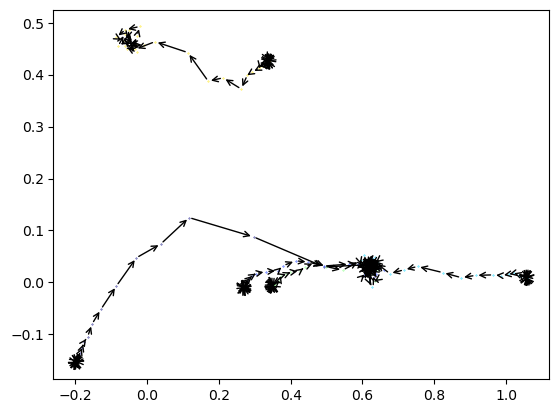

In [1553]:
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 10
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima = []
for j in tqdm(range(ntraj)):
    points_x, points_y, mean,C = affine_invariant_wd(N = 1000, learning_rate = 1e-2, mu = 0, sigma = 1e-3)
    minima.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6 : 
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                 arrowprops={'arrowstyle': '->',  'lw': 1},
                 va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8)
plt.title('Affine Invariant Gradient Flow ')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

(array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.  ,
        0.  , 0.  , 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]),
 array([-150., -145., -140., -135., -130., -125., -120., -115., -110.,
        -105., -100.,  -95.,  -90.,  -85.,  -80.,  -75.,  -70.,  -65.,
         -60.,  -55.,  -50.,  -45.,  -40.,  -35.,  -30.,  -25.,  -20.,
         -15.,  -10.,   -5.,    0.,    5.]),
 <BarContainer object of 31 artists>)

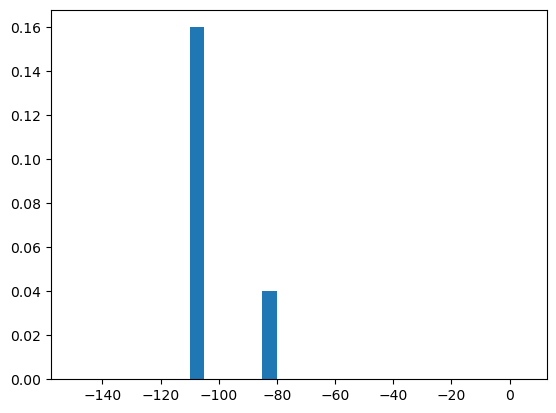

In [1554]:
bins = np.arange(-150,10,5)
plt.hist(minima, density = 'True', bins = bins)

In [1549]:
# Training
def train(intervals, N = 5000, learning_rate = 1e-3, a = 1, tolerance = 1e-2):
    #initialise data
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    
    i = 1
    while 1<=i<=N+1:
        dx, dy = grad_MB(x,y)
        x1 = x - learning_rate*dx
        y1 = y - learning_rate*dy
        #err = np.abs(x1-x)+np.abs(y1-y)
        x = x1
        y = y1
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
        

    return points_x, points_y

def train_nesterov(intervals, N = 5000, learning_rate = 1e-3, a = 1, tolerance = 1e-2):
    intervals = np.arange(1, 1e5, 20)
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    
    u = x
    v = y
    i = 1
    
    while 1<=i<=N+1:
        dx, dy = grad_MB(u,v)
        
        x_new = u - learning_rate*dx
        y_new = v - learning_rate*dy
        
        u = x_new + (i-1)/(i+2)*(x_new-x)
        v = y_new + (i-1)/(i+2)*(y_new-y)
        
        #err = np.abs(x_new-x)+np.abs(y_new-y)
        
        x = x_new
        y = y_new
        
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
    
    return points_x, points_y

def train_MaSS(intervals, N = 5000, learning_rate = 1e-3, a = 1, tolerance = 1e-2):
    intervals = np.arange(1, 1e5, 20)
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    
    u = x
    v = y
    i = 1
    count = 1
    
    while 1<=i<=N+1:
        dx, dy = grad_MB(u,v)
        
        m = 10
        eta2 = learning_rate/m
        
        x_new = u - learning_rate*dx
        y_new = v - learning_rate*dy
        
        u = x_new + (count-1)/(count+2)*(x_new-x) + eta2*dx
        v = y_new + (count-1)/(count+2)*(y_new-y) + eta2*dy
        
        if dx*(x_new-x)+dy*(y_new-y)>0: 
            count = 1
        
        x = x_new
        y = y_new
        
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
    
    return points_x, points_y

def train_sgd(intervals, N = 5000, learning_rate = 1e-3, a = 1, beta = 1, tolerance = 1e-2):
    #initialise data
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    err = np.inf
    i = 1
    while 1<=i<=N+1:
        dx, dy = grad_MB(x,y)
        x1 = x - learning_rate*dx + np.sqrt(2/beta)*np.sqrt(learning_rate)*np.random.normal(0,1)
        y1 = y - learning_rate*dy + np.sqrt(2/beta)*np.sqrt(learning_rate)*np.random.normal(0,1)
        x = x1
        y = y1
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
        
    return points_x, points_y

def train_MF_Hom_SGLD(intervals, N = 5000, learning_rate = 1e-3, M = 20, tolerance = 1e-2):
    
    #initialise data
    intervals = np.arange(1, 1e5, 20)
    #sample from data
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    points_x = []
    points_y = []
    
    Y_x = 0
    Y_y = 0
        
    i = 1
    
    while 1<=i<=N+1:
        
        #update Y
        Y_x_1 = Y_x
        Y_y_1 = Y_y
        
        cal_Y_x = 0
        cal_Y_y = 0
        
        for m in range(1,M+1):
            δ = 0.01/20
            γ = 0.05
            β = 0.1
            λ = 0.05
        
            dx, dy = grad_MB(Y_x_1,Y_y_1)
            
            Y_x_1 = Y_x_1 - δ*(dx-(1/γ)*(x-Y_x_1))\
            + np.sqrt(2*(δ/β))*np.random.normal(0,1)
            Y_y_1 = Y_y_1 - δ*(dy-(1/γ)*(y-Y_y_1))\
            + np.sqrt(2*(δ/β))*np.random.normal(0,1)
            
            cal_Y_x += Y_x_1
            cal_Y_y += Y_y_1
            
        Y_x = Y_x_1
        Y_y = Y_y_1
        
        cal_Y_x /= M
        cal_Y_y /= M
        
        #update model parameters
        Δ = learning_rate
        mu = (x+y)/2
        
        x = x - 1/γ*(x-cal_Y_x)*Δ - λ*(x - mu)*Δ
        y = y - 1/γ*(y-cal_Y_y)*Δ - λ*(y - mu)*Δ
                
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
    return points_x, points_y

def train_HJB(intervals, N = 5000, learning_rate = 1e-3, a = 1, L = 20, test = 'False'):
    intervals = np.arange(1, 1e5, 20)
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    u = x
    v = y
    
    #regularise potential 

    i = 1
    count = 1
    gamma_0 = 0.2
    gamma_1 = 1e-4
    gamma = gamma_0
    
    while 1<=i<=N+1:
        
        if i%L**2 == 0:
            gamma = gamma_0*(1-gamma_1)**(i/L)
        
        heat_x = np.random.normal(0,gamma,L)
        heat_y = gamma*np.random.normal(0,gamma,L)
        
        potential = np.exp(-vMB_potential(u+heat_x, v+heat_y))
        prob = potential/np.sum(potential)

        Dx, Dy = vgrad_MB(u+heat_x,v+heat_y)
        
        dx = np.sum(Dx*prob)
        dy = np.sum(Dy*prob)
        
        x_new = u - learning_rate*dx
        y_new = v - learning_rate*dy
        
        u = x_new + (count-1)/(count+2)*(x_new-x)
        v = y_new + (count-1)/(count+2)*(y_new-y)
        
        if dx*(x_new-x)+dy*(y_new-y)>0: 
            count = 1
        
        x = x_new
        y = y_new
        
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            if test == 'True':
                print('Epoch: {}'.format(i))
                print('x: {}'.format(x))
                print('y: {}'.format(y))
            
        i+=1
    
    return points_x, points_y

def train_HGD(intervals, N = 5000, learning_rate = 1e-4, a = 1, L = 20):
    intervals = np.arange(1, 1e5, 20)
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    
    i = 1
    
    gamma_0 = 0.3
    gamma_1 = 1e-1
    gamma = gamma_0
    
    while 1<=i<=N+1:
        if i%L**2 == 0:
            gamma = gamma_0*(1-gamma_1)**(i/L**2)
            

        heat_x = gamma*np.random.normal(0,1,L)
        heat_y = gamma*np.random.normal(0,1,L)
        
        potential = np.exp(-vMB_potential(x+heat_x, y+heat_y))
        prob = potential/np.sum(potential)

        Dx, Dy = vgrad_MB(x+heat_x,y+heat_y)
        
        dx = np.sum(Dx*prob)
        dy = np.sum(Dy*prob)
        
        x -= learning_rate*dx
        y -= learning_rate*dy
    
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
    
    return points_x, points_y

  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/1751798560.py:225: RuntimeWarning: invalid value encountered in divide
  prob = potential/np.sum(potential)


([], [])

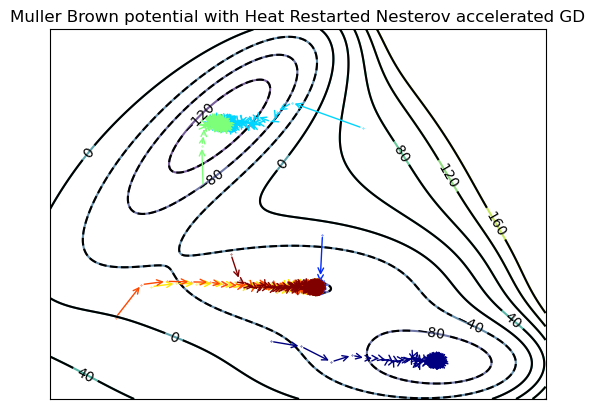

In [1585]:
#Gradient Restarted Nesterov with HJB regularised Potential 
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 1000
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
#minima_HJB = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_HJB(intervals, learning_rate = 1e-4, a = 1)
    minima_HJB.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6: 
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x)-1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.title('Muller Brown potential with Heat Restarted Nesterov accelerated GD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

(array([0.07356322, 0.02446634, 0.00344828, 0.00065681, 0.        ,
        0.0001642 , 0.        , 0.        , 0.03448276, 0.        ,
        0.        , 0.        , 0.        , 0.06321839, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 array([-150., -145., -140., -135., -130., -125., -120., -115., -110.,
        -105., -100.,  -95.,  -90.,  -85.,  -80.,  -75.,  -70.,  -65.,
         -60.,  -55.,  -50.,  -45.,  -40.,  -35.,  -30.,  -25.,  -20.,
         -15.,  -10.,   -5.,    0.,    5.]),
 <BarContainer object of 31 artists>)

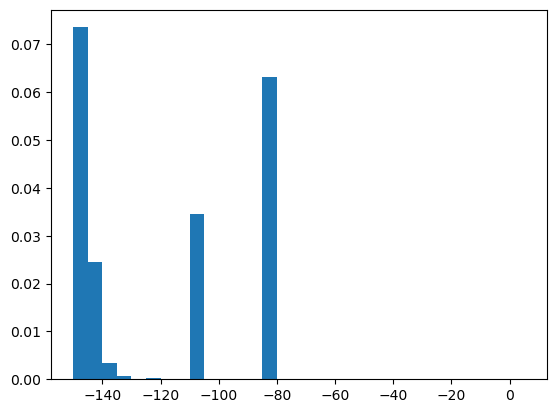

In [1586]:
bins = np.arange(-150, 10, 5)
plt.hist(minima_HJB, bins = bins, density = 'True')

  0%|          | 0/20 [00:00<?, ?it/s]

([], [])

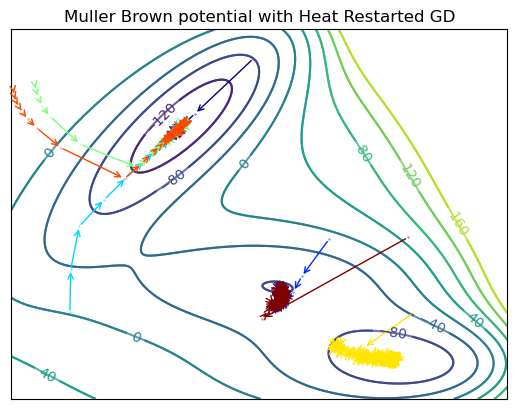

In [848]:
#Heat Restarted GD
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 20
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_HGD = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_HGD(intervals, learning_rate = 1e-4, a = 1)
    minima_HGD.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6 : 
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j], 'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8)
plt.title('Muller Brown potential with Heat Restarted GD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

In [696]:
#Vanilla GD
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 1000
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_vanilla = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train(intervals, learning_rate = 1e-4, a = 1, tolerance = 1e-5)
    minima_vanilla.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6 : 
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j], 'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8)
plt.title('Muller Brown potential with vanilla GD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

([], [])

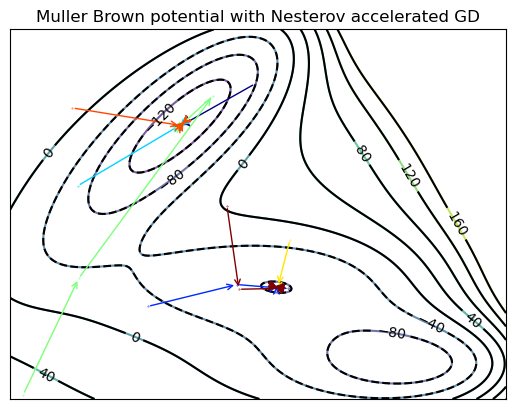

In [617]:
#Nesterov Potential 
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 1000
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_nesterov = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_nesterov(intervals, learning_rate = 1e-4, a = 1, tolerance = 1e-5)
    minima_nesterov.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6: 
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x)-1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8)
plt.title('Muller Brown potential with Nesterov accelerated GD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]

([], [])

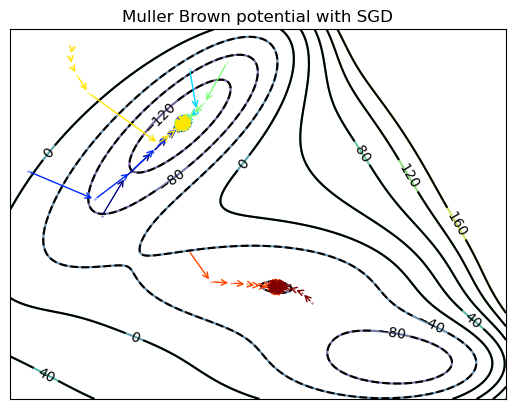

In [1564]:
#sgd

n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 1000
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_sgd = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_sgd(intervals, N = 1000, learning_rate = 1e-4, a = 1, beta = 100, tolerance = 1e-5)
    minima_sgd.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6:
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.title('Muller Brown potential with SGD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]

([], [])

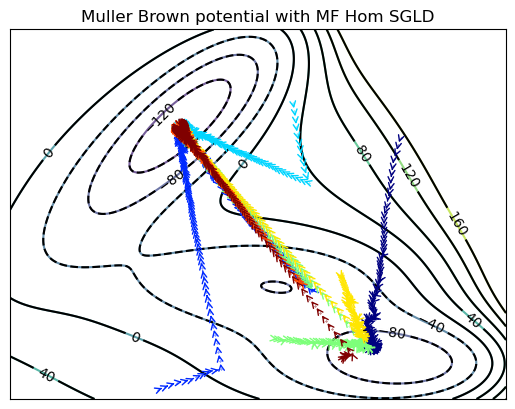

In [625]:
#MF Hom SGLD

n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 1000
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_MF_Hom_SGLD = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_MF_Hom_SGLD(intervals, learning_rate = 1e-4, M = 20)
    minima_MF_Hom_SGLD.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6:
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.title('Muller Brown potential with MF Hom SGLD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

  0%|          | 0/20 [00:00<?, ?it/s]

([], [])

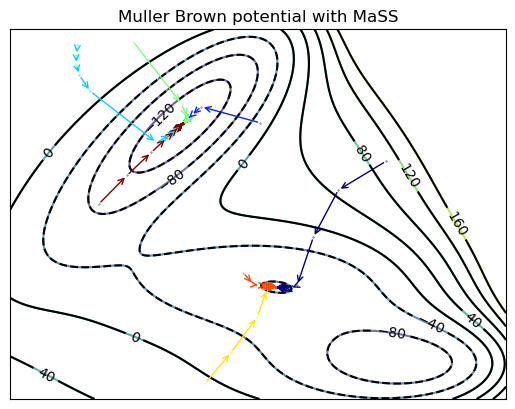

In [602]:
#MaSS

n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 20
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_MaSS = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_MaSS(intervals, learning_rate = 1e-4, a = 1)
    minima_MaSS.append(MB_potential(points_x[-1],points_y[-1]))
    if j <= 6:
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.title('Muller Brown potential with MaSS')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

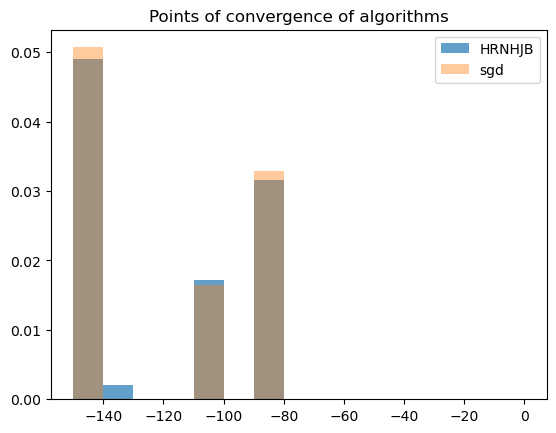

In [1587]:
bins = np.arange(-150, 10, 10)
plt.title('Points of convergence of algorithms')
#plt.hist(minima_MF_Hom_SGLD, alpha = 0.7, bins = bins, density = 'True', label = 'MF Hom SGLD')
plt.hist(minima_HJB, alpha = 0.7, bins = bins, density = 'True', label = 'HRNHJB')
plt.hist(minima_sgd, alpha = 0.4,  bins = bins, density = 'True', label = 'sgd')
#plt.hist(minima, bins = bins, density = 'True', label = 'Affine invariant WD')
plt.legend()

/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/1689129583.py:15: RuntimeWarning: divide by zero encountered in log
  return -np.log(gibbs)


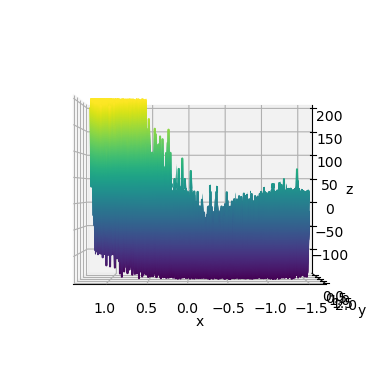

In [1475]:
#contour plot of Muller-Brown potential 
n = 256

x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

def reg_potential(x,y):
    gibbs = 0
    L = 10
    noise_x = np.random.normal(0,0.4, L)
    noise_y = np.random.normal(0,0.4, L)
    gibbs = np.mean(np.exp(-vMB_potential(x+noise_x,y+noise_y)))
        
    return -np.log(gibbs)
vreg_potential = np.vectorize(reg_potential)

Z = vreg_potential(X,Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(0, 90)
plt.contour(X, Y, Z.clip(max = 200), 500, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

Text(0, 0.5, 'y')

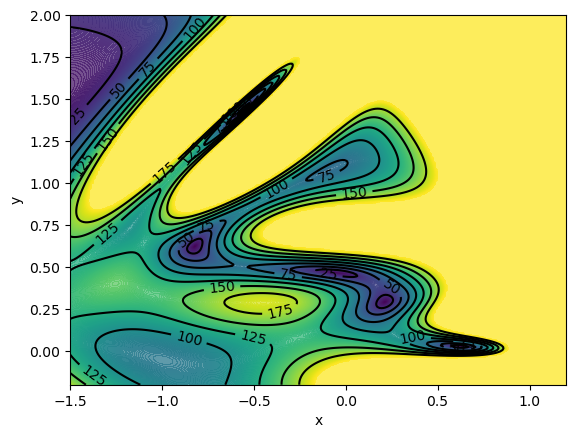

In [794]:
n = 256

x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

Z = (vgrad_MB(X, Y)[0]**2+vgrad_MB(X, Y)[1]**2)**(0.5)

plt.contourf(X, Y, Z.clip(max = 200), 500, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, Z.clip(max = 200), 8, colors='black')
plt.clabel(C, inline=1, fontsize=10)
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

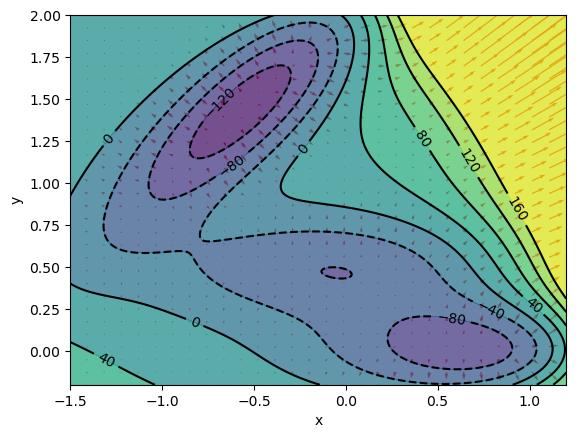

In [791]:
n = 256

x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

x1 = np.linspace(-1.5, 1.2, 30)
y1 = np.linspace(-0.2, 2, 30)
X1, Y1 = np.meshgrid(x1, y1)
U, V = vgrad_MB(X1, Y1)

plt.quiver(X1,Y1,U,V, color = 'red')
plt.contourf(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.clabel(C, inline=1, fontsize=10)
plt.xlabel('x')
plt.ylabel('y')

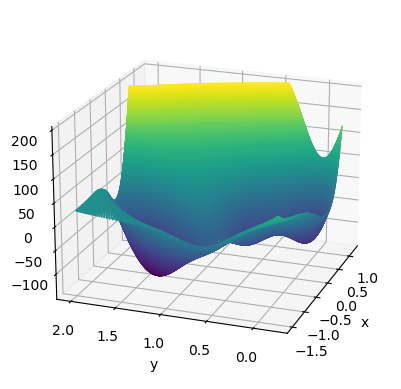

In [1384]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(20, 200)
Z = vMB_potential(X,Y)
plt.contour(X, Y, Z.clip(max=200), 1000, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

# General Observations:
- Most algorithms on the MB potential get stuck equally on two local minima, i.e. the global one (which is narrow) and the one with the next smallest local minimum
- Convolving with a solution to the heat equation does not improve performance as the narrow steep global minimum (as seen from the plot) is smeared out first thus giving no hope of real convergence, unless the algorithms is lucky with the initialisation
- The Hom-MF-SGLD works surprisingly well against all others since it performs a gradient flow of a regularised potential, where regularisation is done at the level of the gibbs measure
- Idea, maybe sample points (to initialise GD) more judiciously, i.e. with gibbs measure (inspired by Andrew Stuart's paper ) by performing a gradient flow and use that 'educated guess as the initialisation of a gd algorithm. (e.g. Wasserstein gradient flow, i.e. sgd on log of Gibbs measure of potential, or affine invariant Wasserstein)
- This idea seems to perform better that all algorithms except the MF-Hom-SGLD algorithm
- Regularising using the HJB equation (essentially performed in the MF-Hom_SGLD algorithm) is better suited to minima that are narrower compared to regularisation with the heat equation that destroys such peaks first (due to large curvature)
- Tried regularising wrt soln of HJB equation (motivated by regularising properties discussed in the 2017 paper by Chaudhari et al. entitled 'Deep Relaxation:...') directly and apply nesterov's accelerated gd algorithm with gradient restarting